# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)
4. [Ejercicio #1](#eje1)
5. [Ejercicio #2](#eje2)
6. [Ejercicio #3](#eje3)

**Equipo #14**

José Luis Parada Gutiérrez - A00939669

Julian Jesús Moreno Ovando - A01795915

Mario Raúl García Ramírez - A01658682

Juan Pablo Carvajal Acosta - A01796843

## Libraries <a name="libraries"></a>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
DIR = "/content/drive/MyDrive/Vision"
os.chdir(DIR)

Mounted at /content/drive


## Simple Convolution <a name="simple"></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="data/convolution.png" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__.

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [3]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [4]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [5]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros

    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

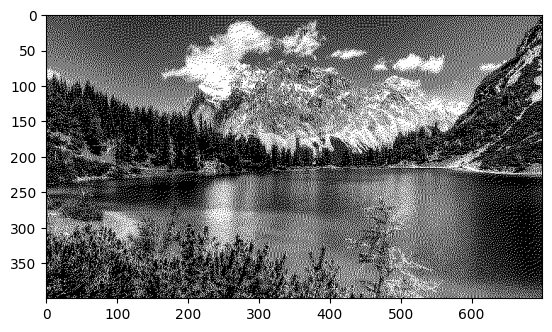

In [6]:
image = Image.open('data/image.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [7]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

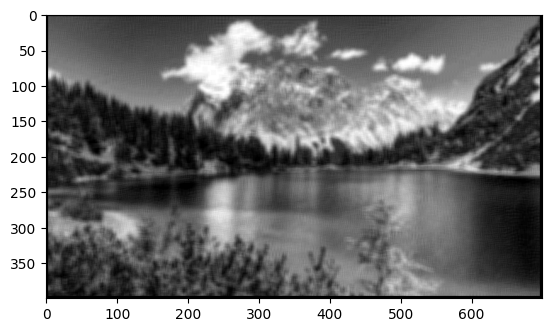

In [8]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a name="pytorch"></a>

In [10]:
from PIL import Image

img = Image.open('data/image.jpg')
# Use LANCZOS (same as the old ANTIALIAS)
img.thumbnail((256, 256), Image.Resampling.LANCZOS)


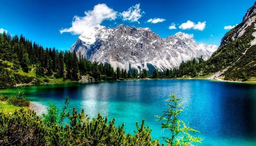

In [11]:
img

In [12]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [13]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [14]:
input = to_tensor(img)
input.shape


torch.Size([1, 146, 256])

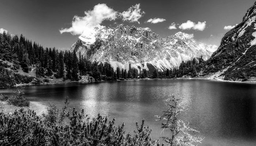

In [15]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [16]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [17]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[ 0.2194,  0.1722,  0.1718,  ...,  0.2390,  0.2093,  0.0308],
         [ 0.2289,  0.0790,  0.0784,  ...,  0.0870, -0.0012, -0.1369],
         [ 0.2372,  0.0831,  0.0794,  ...,  0.0388, -0.0514, -0.1401],
         ...,
         [ 0.0481, -0.0149,  0.0317,  ...,  0.0954,  0.0964, -0.0346],
         [ 0.0939,  0.0646,  0.0545,  ...,  0.0932,  0.0958, -0.0377],
         [ 0.0411,  0.0227, -0.0637,  ..., -0.1214, -0.1225, -0.1602]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [18]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 146, 256])

In [19]:
output = conv(input)
output.shape

torch.Size([1, 1, 146, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [20]:
output.shape

torch.Size([1, 1, 146, 256])

We need to remove the first dimension before converting to a PIL object.

In [21]:
output.data.squeeze(dim=0).shape

torch.Size([1, 146, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

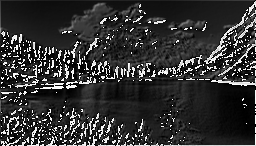

In [22]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

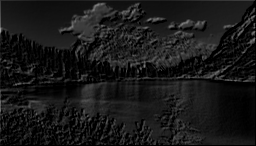

In [23]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [24]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

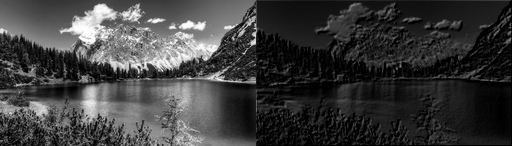

In [25]:
display(input, output)

### Identity

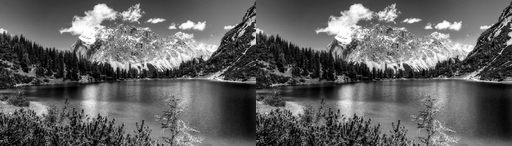

In [26]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


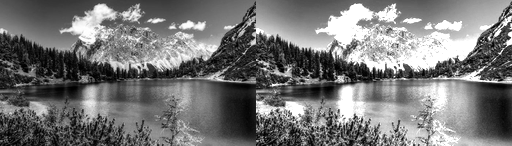

In [27]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


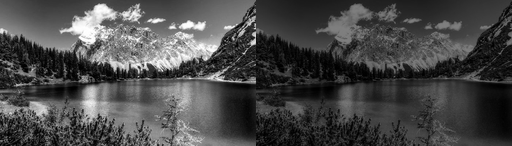

In [28]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


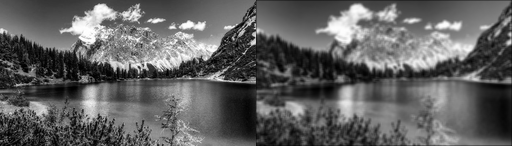

In [29]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


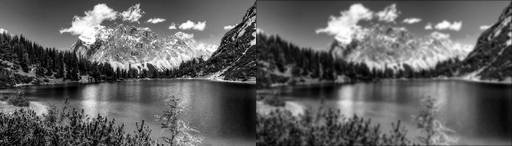

In [30]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


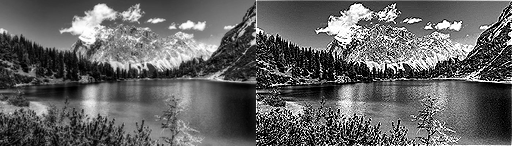

In [31]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


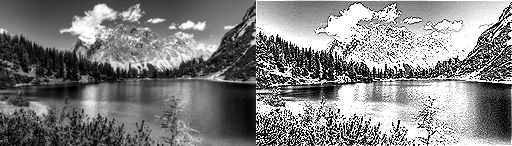

In [32]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


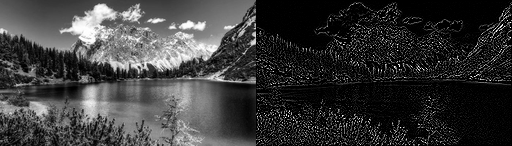

In [33]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

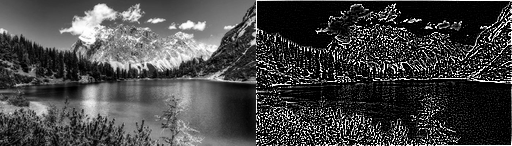

In [34]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

In [35]:
# TODO: Challenge, hard image with hard transformations

## Ejercicio #1 <a name="eje1"></a> - Deteccion de lineas
*   Prewitt
*   Sobel
*   Laplaciano


###Prewitt



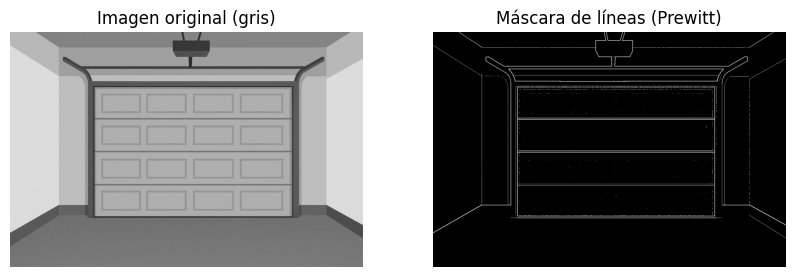

In [46]:
# --- 1) Cargar imagen ---
img = Image.open('data2/image14.png').convert("L")
I = np.asarray(img, dtype=np.float32) / 255.0

# --- 2) Prewitt ---
P = np.pad(I, ((1,1),(1,1)), mode="reflect")

P00=P[:-2, :-2]; P01=P[:-2,1:-1]; P02=P[:-2,2:]
P10=P[1:-1, :-2]; P11=P[1:-1,1:-1]; P12=P[1:-1,2:]
P20=P[2:,  :-2]; P21=P[2:, 1:-1]; P22=P[2:, 2:]

Gx = (-P00 + P02) + (-P10 + P12) + (-P20 + P22)
Gy = ( P00 + P01 + P02) - (P20 + P21 + P22)

mag = np.hypot(Gx, Gy)
mag = mag / (mag.max() + 1e-8)

# --- 3) Umbral simple ---
THRESH = 0.2  # ajusta este valor para más/menos líneas
mask = (mag >= THRESH).astype(np.float32)

# --- 4) Mostrar ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Imagen original (gris)")
plt.imshow(I, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Máscara de líneas (Prewitt)")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.show()


###Sobel

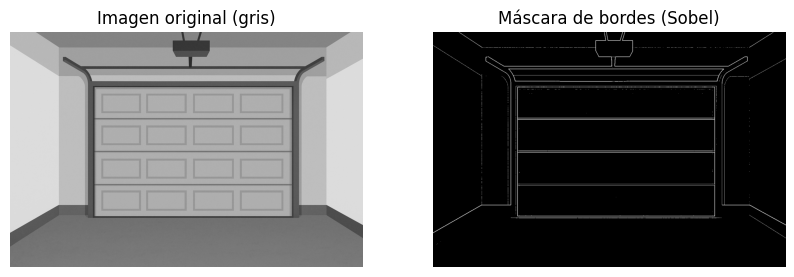

In [48]:
# --- 1) Cargar imagen ---
img = Image.open('data2/image14.png').convert("L")
I = np.asarray(img, dtype=np.float32) / 255.0

# --- 2) Sobel ---
P = np.pad(I, ((1,1),(1,1)), mode="reflect")

P00=P[:-2, :-2]; P01=P[:-2,1:-1]; P02=P[:-2,2:]
P10=P[1:-1, :-2];               P12=P[1:-1,2:]
P20=P[2:,  :-2]; P21=P[2:, 1:-1]; P22=P[2:, 2:]

# Gx = [[-1,0,1],[-2,0,2],[-1,0,1]]
Gx = (-P00 + P02) + (-2*P10 + 2*P12) + (-P20 + P22)
# Gy = [[ 1,2,1],[ 0,0,0],[-1,-2,-1]]
Gy = ( P00 + 2*P01 + P02) - (P20 + 2*P21 + P22)

mag = np.hypot(Gx, Gy)
mag = mag / (mag.max() + 1e-8)

# --- 3) Umbral simple ---
THRESH = 0.2  # ajusta este valor para más/menos líneas
mask = (mag >= THRESH).astype(np.float32)

# --- 4) Mostrar ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Imagen original (gris)"); plt.imshow(I, cmap="gray"); plt.axis("off")
plt.subplot(1,2,2); plt.title("Máscara de bordes (Sobel)"); plt.imshow(mask, cmap="gray"); plt.axis("off")
plt.show()


###Laplaciano

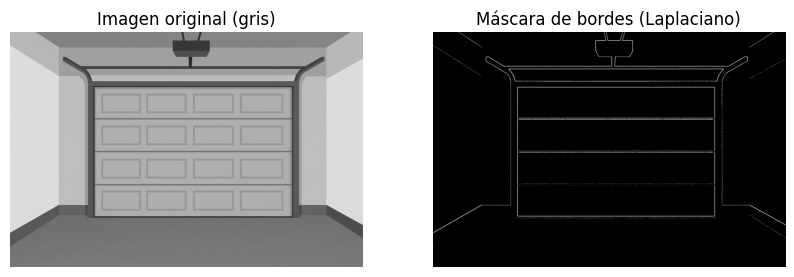

In [50]:
# --- 1) Cargar imagen ---
img = Image.open("data2/image14.png").convert("L")
I = np.asarray(img, dtype=np.float32) / 255.0

# --- 2) Laplaciano ---
P = np.pad(I, ((1,1),(1,1)), mode="reflect")

P00=P[:-2, :-2]; P01=P[:-2,1:-1]; P02=P[:-2,2:]
P10=P[1:-1, :-2]; P11=P[1:-1,1:-1]; P12=P[1:-1,2:]
P20=P[2:,  :-2]; P21=P[2:, 1:-1]; P22=P[2:, 2:]

# Kernel Laplaciano = [[0,-1,0],[-1,4,-1],[0,-1,0]]
lap = (4*P11) - (P01 + P10 + P12 + P21)

# Normalizar magnitud a [0,1]
mag = np.abs(lap)
mag = mag / (mag.max() + 1e-8)

# --- 3) Umbral simple ---
THRESH = 0.2
mask = (mag >= THRESH).astype(np.float32)

# --- 4) Mostrar ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Imagen original (gris)"); plt.imshow(I, cmap="gray"); plt.axis("off")
plt.subplot(1,2,2); plt.title("Máscara de bordes (Laplaciano)"); plt.imshow(mask, cmap="gray"); plt.axis("off")
plt.show()


# Complejidad Algorítmica de Prewitt, Sobel y Laplaciano

Todos estos operadores son **convoluciones 2D** con un **kernel fijo de 3×3** aplicado a cada píxel.

- Imagen de tamaño **N × M**  
- Kernel de tamaño **k × k** (aquí k = 3)  

El costo de aplicar un kernel en un píxel es proporcional a **k²** operaciones.  
Por lo tanto:

$$
T(N,M) = O(N \cdot M \cdot k^2)
$$

Como \(k = 3\) (constante):

$$
T(N,M) = O(N \cdot M)
$$

Es decir, todos son **lineales en el número de píxeles**.

---

## Comparación entre algoritmos

### 1. **Prewitt**
- Usa **dos kernels** (Gx y Gy).  
- Cada kernel ≈ 9 operaciones.  
- Total ≈ 18 operaciones/píxel + cálculo de magnitud.  
- Complejidad: **O(N·M)** con constante intermedia.

### 2. **Sobel**
- Igual que Prewitt, pero con pesos ±2.  
- Total ≈ 18 operaciones/píxel + cálculo de magnitud.  
- Complejidad: **O(N·M)**, ligeramente más costoso que Prewitt.

### 3. **Laplaciano**
- Usa **un solo kernel**.  
- Total ≈ 5 operaciones/píxel.  
- No necesita magnitud vectorial (no hay Gx, Gy).  
- Complejidad: **O(N·M)** con menor constante.

---

## Conclusiones

- **Todos tienen la misma complejidad asintótica:**  
  $$
  O(N \cdot M)
  $$  

- **Más eficiente:** Laplaciano (menos operaciones).  
- **Mejor calidad de bordes:** Sobel.  
- **Prewitt** es un intermedio (simple, pero más ruidoso que Sobel).  


## Resultados ejercicio #1

En este ejercicio vimos que los operadores **Prewitt, Sobel y Laplaciano** al final hacen lo mismo en cuanto a complejidad: recorren todos los píxeles de la imagen y trabajan en **tiempo lineal**. La diferencia está en los detalles: el **Laplaciano** es más rápido porque hace menos cuentas, el **Sobel** detecta mejor los bordes porque resiste más al ruido, y el **Prewitt** es la opción más simple pero también más ruidosa.  

La idea que queda es que no basta con ver la teoría, sino que hay que pensar en la práctica: a veces importa más la calidad de los bordes o la resistencia al ruido que el número de operaciones. Todo depende de lo que quieras lograr con la imagen.


## Ejercicio #2 <a name="eje2"></a>

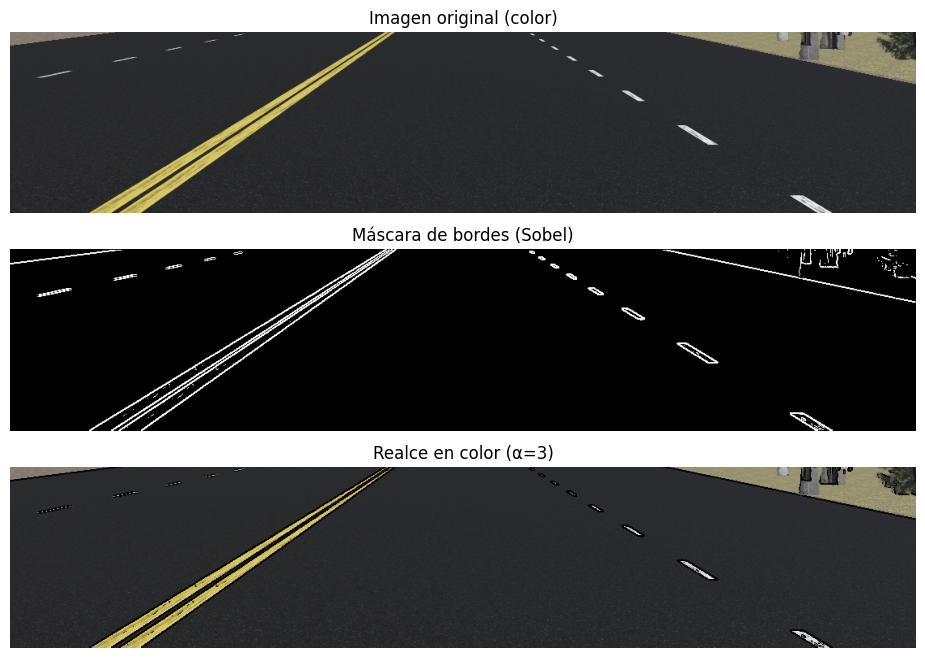

In [117]:
# Parámetros
IMG_PATH = "data2/image22.jpg"
THRESH   = 0.25                   # umbral 0..1 para la máscara
ALPHA    = 3                     # >1: más alto = líneas más enfatizadas

# --- 1) Cargar imagen ---
I_color = np.asarray(Image.open(IMG_PATH).convert("RGB"), dtype=np.float32) / 255.0
I_gray = np.dot(I_color[...,:3], [0.2989, 0.5870, 0.1140])

# --- 2) Sobel (sin OpenCV), padding reflect y desplazamientos ---
P = np.pad(I_gray, ((1,1),(1,1)), mode="reflect")
P00=P[:-2, :-2]; P01=P[:-2,1:-1]; P02=P[:-2,2:]
P10=P[1:-1, :-2];               P12=P[1:-1,2:]
P20=P[2:,  :-2]; P21=P[2:, 1:-1]; P22=P[2:, 2:]

# Sobel Gx / Gy
Gx = (-P00 + P02) + (-2*P10 + 2*P12) + (-P20 + P22)
Gy = ( P00 + 2*P01 + P02) - (P20 + 2*P21 + P22)

mag = np.hypot(Gx, Gy)
mag = mag / (mag.max() + 1e-8)

# --- 3) Máscara binaria de bordes ---
mask = (mag >= THRESH).astype(np.float32)

# --- 4) Realce en color: multiplicar cada canal ---
enhanced = np.clip(I_color - (ALPHA - 1.0) * mask[...,None], 0.0, 1.0)

# --- 5) Mostrar ---
plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.title("Imagen original (color)")
plt.imshow(I_color)
plt.axis("off")

plt.subplot(3,1,2)
plt.title("Máscara de bordes (Sobel)")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(3,1,3)
plt.title(f"Realce en color (α={ALPHA})")
plt.imshow(enhanced)
plt.axis("off")

plt.show()


Resultados ejercicio #2 sin utilizar OpenCV

..........

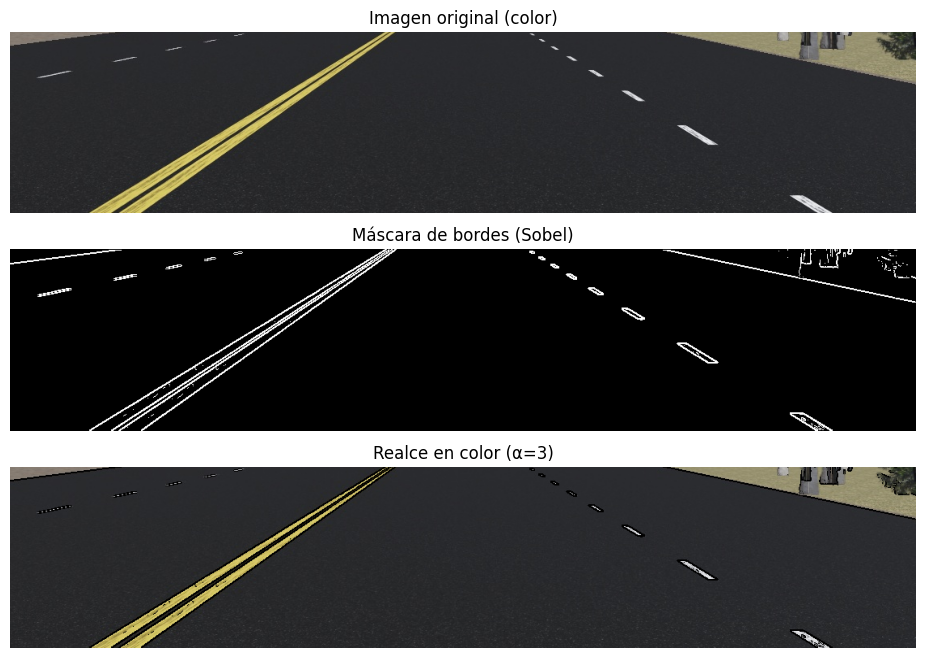

In [100]:
# Parámetros
IMG_PATH = "data2/image22.jpg"
THRESH   = 0.25   # umbral 0..1 para la máscara
ALPHA    = 3      # factor > 1

# --- 1) Cargar imagen ---
img_bgr  = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)

I_color = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
I_gray  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

# --- 2) Sobel ---
Gx = cv2.Sobel(I_gray, cv2.CV_32F, 1, 0, ksize=3)
Gy = cv2.Sobel(I_gray, cv2.CV_32F, 0, 1, ksize=3)
mag = cv2.magnitude(Gx, Gy)
mag = cv2.normalize(mag, None, 0.0, 1.0, cv2.NORM_MINMAX)

# --- 3) Máscara binaria de bordes ---
_, mask = cv2.threshold(mag, THRESH, 1.0, cv2.THRESH_BINARY)

# --- 4) Realce en color: multiplicar cada canal ---
enhanced = np.clip(I_color - (ALPHA * mask[..., None]), 0.0, 1.0)

# --- 5) Mostrar ---
plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.title("Imagen original (color)")
plt.imshow(I_color)
plt.axis("off")

plt.subplot(3,1,2)
plt.title("Máscara de bordes (Sobel)")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(3,1,3)
plt.title(f"Realce en color (α={ALPHA})")
plt.imshow(enhanced)
plt.axis("off")

plt.show()


Resultados ejercicio #2 Utilizando OpenCV

..........

## Ejercicio #3 <a name="eje3"></a>

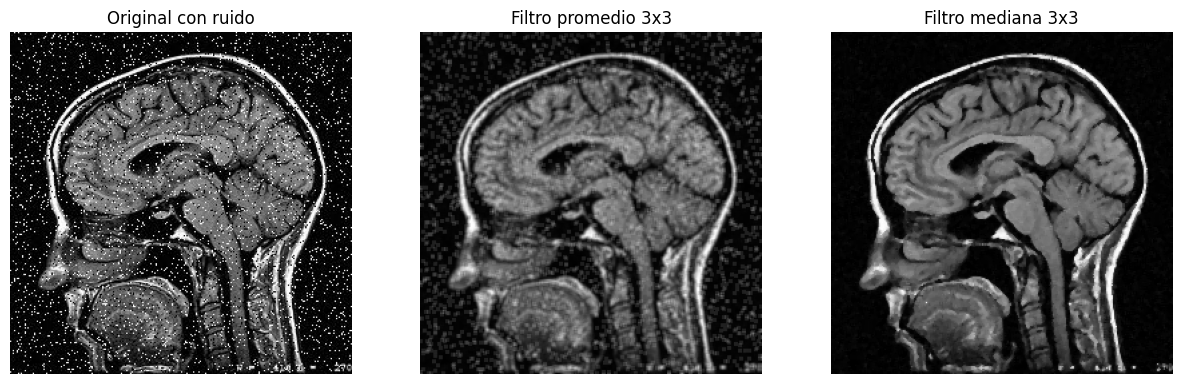

In [130]:
# --- 1) Cargar imagen ---
img = cv2.imread("data2/image24.jpg", cv2.IMREAD_GRAYSCALE)

# Normalizar a [0,1]
img = img.astype(np.float32) / 255.0

# --- 2) Suavizado con promedio (3x3)---
avg_blur = cv2.blur(img, (3,3))

# --- 3) Suavizado con mediana (3x3) ---
median_blur = cv2.medianBlur((img*255).astype(np.uint8), 3).astype(np.float32)/255.0

# --- 4) Mostrar ---
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Original con ruido"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title("Filtro promedio 3x3"); plt.imshow(avg_blur, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Filtro mediana 3x3"); plt.imshow(median_blur, cmap="gray"); plt.axis("off")
plt.show()


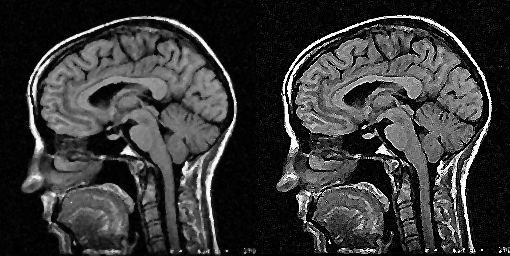

In [131]:
# Convertir a tensor [1,1,H,W]
input = torch.from_numpy(median_blur).unsqueeze(0).unsqueeze(0)

# Definir conv
conv = torch.nn.Conv2d(1, 1, kernel_size=3, bias=False)
conv.weight.data = torch.tensor([[[[0., -1., 0.],
                                   [-1., 5., -1.],
                                   [0., -1., 0.]]]])

# Aplicar
output = conv(input)
display(input, output)

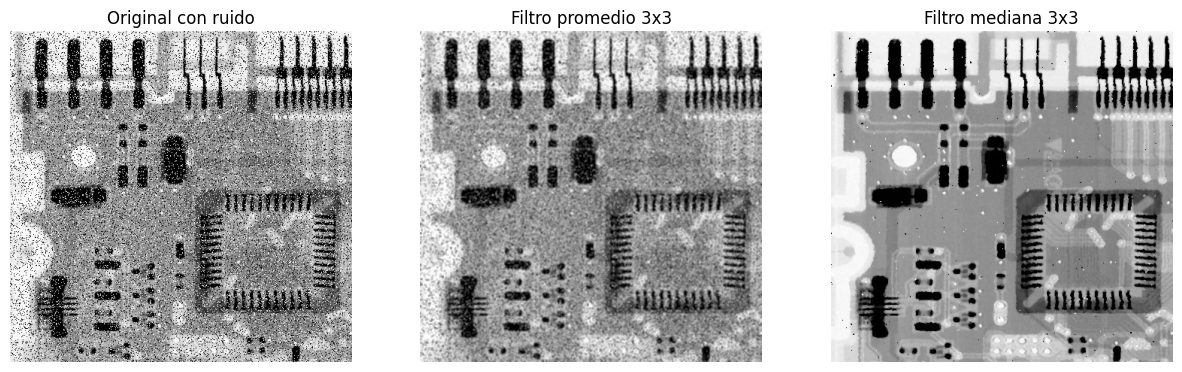

In [98]:
# --- 1) Cargar imagen ---
img = cv2.imread("data2/image18.png", cv2.IMREAD_GRAYSCALE)

# Normalizar a [0,1]
img = img.astype(np.float32) / 255.0

# --- 2) Suavizado con promedio (3x3)---
avg_blur = cv2.blur(img, (3,3))

# --- 3) Suavizado con mediana (3x3) ---
median_blur = cv2.medianBlur((img*255).astype(np.uint8), 3).astype(np.float32)/255.0

# --- 4) Mostrar ---
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Original con ruido"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title("Filtro promedio 3x3"); plt.imshow(avg_blur, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Filtro mediana 3x3"); plt.imshow(median_blur, cmap="gray"); plt.axis("off")
plt.show()


Resultados ejercicio #3

..........

### Conclusión

.....

### Referencias

1. Gonzalez, R. C., & Woods, R. E. (2018).  
*Intensity transformations and spatial filtering.* En *Digital image processing* (4th ed.). Pearson.  

2. Singh, R. P., & Dixit, M. (2015).  
Histogram equalization: A strong technique for image enhancement. *International Journal of Signal Processing, Image Processing and Pattern Recognition.*  
https://doi.org/10.14257/ijsip.2015.8.8.35  

3. Kang, B., Lee, S., & Paik, J. (2011).  
Adaptive height-modified histogram equalization and chroma correction in YCbCr color space for fast backlight image compensation. *IEEE Transactions on Consumer Electronics, 57*(1), 380–387.  

4. GeeksforGeeks. (s.f.).  
Intensity Transformation Operations on Images. *GeeksforGeeks.* Recuperado de:  
https://www.geeksforgeeks.org/python-intensity-transformation-operations-on-images/  

5. SpMallick, S. (s.f.).  
Simple Background Estimation in Videos using OpenCV (C++/Python). *LearnOpenCV.*  
https://learnopencv.com/simple-background-estimation-in-videos-using-opencv-c-python/  

6. Schnabel, M. (2019).  
*opencv-motion-detector:* A Python/OpenCV script that uses background subtraction to detect motion in a live feed or video. *GitHub.*  
https://github.com/markschnabel/opencv-motion-detector  
